In [38]:
# Importera nödvändiga bibliotek
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Ladda och förbered data

In [39]:
# Läs in datasets
customer_data = pd.read_csv('customer_details.csv')  # Kundinformation
transactions = pd.read_csv('transactions.csv')    # Transaktionsdata

# Visa de första raderna i varje dataset
print("Customer Data:")
print(customer_data.head())

print("\nTransaction Data:")
print(transactions.head())


Customer Data:
   CustomerID FirstName  LastName                 Email          Phone
0        1000      Jane     Brown  user1000@example.com  1234567891000
1        1001     Chris   Johnson  user1001@example.com  1234567891001
2        1002     Emily     Brown  user1002@example.com  1234567891002
3        1003      Jane     Smith  user1003@example.com  1234567891003
4        1004     Chris  Williams  user1004@example.com  1234567891004

Transaction Data:
   TransactionID  CustomerID      TransactionDate  Amount     Category
0              0        2869  2023-01-01 00:00:00  242.74  Electronics
1              1        1424  2023-01-01 01:00:00  132.46     Clothing
2              2        1948  2023-01-01 02:00:00   66.99     Clothing
3              3        3414  2023-01-01 03:00:00  412.16  Electronics
4              4        1436  2023-01-01 04:00:00  310.24    Groceries


In [40]:
# Konvertera TransactionDate till datetime-format
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Kontrollera att datum har konverterats korrekt
print(transactions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   int64         
 1   CustomerID       1000 non-null   int64         
 2   TransactionDate  1000 non-null   datetime64[ns]
 3   Amount           1000 non-null   float64       
 4   Category         1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 39.2+ KB
None


In [41]:
# Beräkna senaste transaktionsdatum för varje kund
last_transaction = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction.columns = ['CustomerID', 'LastTransactionDate']

# Visa resultatet
print(last_transaction.head())


   CustomerID LastTransactionDate
0        1000 2023-01-25 08:00:00
1        1006 2023-01-21 07:00:00
2        1008 2023-01-28 20:00:00
3        1020 2023-01-05 07:00:00
4        1025 2023-01-02 11:00:00


In [42]:
# Beräkna antal dagar sedan senaste transaktion
today = datetime.now()
last_transaction['DaysSinceLastTransaction'] = (today - last_transaction['LastTransactionDate']).dt.days

# Kontrollera att kolumnen har lagts till korrekt
print(last_transaction.head())


   CustomerID LastTransactionDate  DaysSinceLastTransaction
0        1000 2023-01-25 08:00:00                       678
1        1006 2023-01-21 07:00:00                       682
2        1008 2023-01-28 20:00:00                       674
3        1020 2023-01-05 07:00:00                       698
4        1025 2023-01-02 11:00:00                       701


In [43]:
# Slå ihop kunddata och transaktionsdata baserat på CustomerID
merged_data = pd.merge(customer_data, last_transaction, on='CustomerID', how='left')

# Fyll saknade värden i DaysSinceLastTransaction (t.ex. kunder utan transaktioner)
merged_data['DaysSinceLastTransaction'] = merged_data['DaysSinceLastTransaction'].fillna(9999)

# Kontrollera resultatet
print(merged_data.head())


   CustomerID FirstName  LastName                 Email          Phone  \
0        1000      Jane     Brown  user1000@example.com  1234567891000   
1        1001     Chris   Johnson  user1001@example.com  1234567891001   
2        1002     Emily     Brown  user1002@example.com  1234567891002   
3        1003      Jane     Smith  user1003@example.com  1234567891003   
4        1004     Chris  Williams  user1004@example.com  1234567891004   

  LastTransactionDate  DaysSinceLastTransaction  
0 2023-01-25 08:00:00                     678.0  
1                 NaT                    9999.0  
2                 NaT                    9999.0  
3                 NaT                    9999.0  
4                 NaT                    9999.0  


In [44]:
# Definiera churn: kunder som inte har gjort en transaktion på över 90 dagar
merged_data['Churn'] = merged_data['DaysSinceLastTransaction'].apply(lambda x: 1 if x > 90 else 0)

# Kontrollera resultatet
print(merged_data[['CustomerID', 'DaysSinceLastTransaction', 'Churn']].head())


   CustomerID  DaysSinceLastTransaction  Churn
0        1000                     678.0      1
1        1001                    9999.0      1
2        1002                    9999.0      1
3        1003                    9999.0      1
4        1004                    9999.0      1


In [45]:
# Välj funktioner och målvariabel
X = merged_data[['DaysSinceLastTransaction']]  # Lägg till fler funktioner om det behövs
y = merged_data['Churn']

# Kontrollera dimensionerna
print("Features Shape:", X.shape)
print("Target Shape:", y.shape)


Features Shape: (4000, 1)
Target Shape: (4000,)


# Dela upp data

In [46]:
# Dela upp data i tränings- och testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Kontrollera dimensionerna för tränings- och testset
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Training Set Shape: (2800, 1)
Test Set Shape: (1200, 1)


In [47]:
# Skapa och träna en Random Forest-modell
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Gör förutsägelser
predictions = model.predict(X_test)


# Implementera och träna modellen

In [48]:
# Beräkna mätvärden
print("\nModel Performance Metrics:")
print("Accuracy:", accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))



Model Performance Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1200

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



# Utvärdera modellen

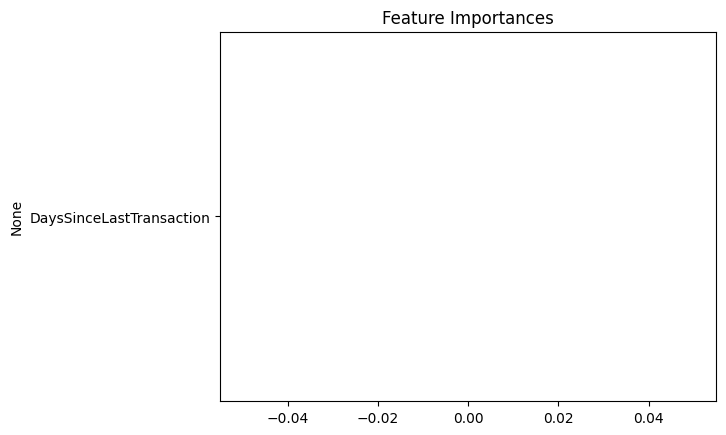

In [50]:
# Kontrollera funktionens betydelse
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.show()


# Visualisera funktionens betydelse

c:\Users\danne\Desktop\github\jupyter\.venv\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


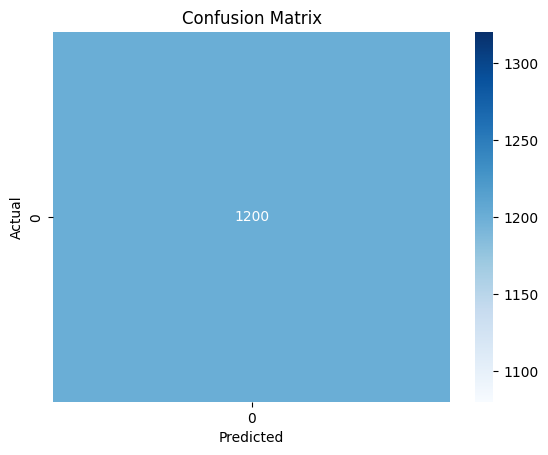

In [51]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()